__Marketinganalyse__

Modulprojekt für die Vorlesung __Applied Statistics__

_Dozent:_ Prof. Dr. Jan Kirenz
_Studenten:_ Stephanie Flohr, Benedikt Haußner, Robert Masendorf

**Hinweis:** Zu korrekten Darstellung der Ergebnisse in den MarkDowns muss die Nbextension ```Python Markdown``` aktiviert sein. Zusätzlich muss ein ```Trusted```Kernel verwendet werden.

In [1]:
#import sys
#if not sys.warnoptions:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# Import data
First you must **import** your data into Python. This typically means that you take data stored in a file, database, or web API, and load it into a DataFrame in Python (using pandas). 

Die von [hier](https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/) verwendeten Daten wurden im März 2015 von der IBM als Beispieldatensatz unter dem Namen `SAMPLE DATA: Marketing Customer Value Analysis`veröffentlicht.

In [3]:
df = pd.read_csv('marketing_customer_marketing_raw_data.csv')

In [4]:
df.shape

(9134, 24)

# Tidying data
Once you’ve imported your data, it is a good idea to tidy it. **Tidying** your data means storing it in a consistent form that matches the semantics of the dataset with the way it is stored. In brief, when your data is tidy, each column is a variable, and each row is an observation. Tidy data is important because the consistent structure lets you focus your struggle on questions about the data.

## Data inspection

In [7]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [8]:
df.head(2)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


In [9]:
# Change column name => some columns could not use
df = df.rename(index=str, columns={"Customer":"Customer_ID",
                                   "Customer Lifetime Value":"Customer_Lifetime_Value",
                                   "Effective To Date":"Effective_To_Date", 
                                   "EmploymentStatus":"Employment_Status", 
                                   "Location Code":"Location_Code", 
                                   "Marital Status":"Marital_Status",
                                   "Monthly Premium Auto":"Monthly_Premium_Auto",
                                   "Months Since Last Claim":"Months_Since_Last_Claim",
                                   "Months Since Policy Inception":"Months_Since_Policy_Inception",
                                   "Number of Open Complaints":"Number_of_Open_Complaints",
                                   "Number of Policies":"Number_of_Policies",
                                   "Policy Type":"Policy_Type",
                                   "Renew Offer Type":"Renew_Offer_Type",
                                   "Sales Channel":"Sales_Channel",
                                   "Total Claim Amount":"Total_Claim_Amount",
                                   "Vehicle Class":"Vehicle_Class", 
                                   "Vehicle Size":"Vehicle_Size"})

In [10]:
# Chek for duplicates and print results
print(f'Customer: {len(df["Customer_ID"])}')
# Count the number of individual customers
print(f'Unique Customer: {len(df["Customer_ID"].value_counts())}')

Customer: 9134
Unique Customer: 9134


In [11]:
df.head(2)

,Customer_ID,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,Employment_Status,Gender,Income,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


#### __ToDo:__ Weitere Ideen für Categorical Variables einbauen? Statt Customer => Customer_ID eintragen?

In [13]:
# df.Effective_To_Date = pd.to_datetime(df['Effective_To_Date'].dt.strftime('%d/%m/%Y')
df.Effective_To_Date = pd.to_datetime(df['Effective_To_Date'])
print(df.Effective_To_Date)

0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
5      2011-01-25
6      2011-02-24
7      2011-01-18
8      2011-01-26
9      2011-02-17
10     2011-02-21
11     2011-01-06
12     2011-02-06
13     2011-01-10
14     2011-01-18
15     2011-01-17
16     2011-02-06
17     2011-01-05
18     2011-02-27
19     2011-01-14
20     2011-02-19
21     2011-01-21
22     2011-01-26
23     2011-02-24
24     2011-02-05
25     2011-01-29
26     2011-02-28
27     2011-02-12
28     2011-02-02
29     2011-02-07
          ...    
9104   2011-01-09
9105   2011-02-22
9106   2011-01-12
9107   2011-01-26
9108   2011-01-28
9109   2011-01-25
9110   2011-01-14
9111   2011-02-07
9112   2011-02-12
9113   2011-01-06
9114   2011-02-23
9115   2011-02-17
9116   2011-01-26
9117   2011-01-20
9118   2011-02-10
9119   2011-01-13
9120   2011-02-19
9121   2011-01-17
9122   2011-02-01
9123   2011-01-19
9124   2011-01-20
9125   2011-01-31
9126   2011-01-09
9127   2011-02-12
9128   201

In [14]:
# Select categorical variable
# Categorical (Binary (1/0), Nominal (mehrere kategorischen Ausprägungen, nicht sortiert), Ordinal (sortierbar))
df['Customer_ID'] = pd.Categorical(df['Customer_ID'])
df['State'] = pd.Categorical(df['State'])
df['Education'] = pd.Categorical(df['Education'])
df['Marital_Status'] = pd.Categorical(df['Marital_Status'])
df['Response'] = pd.Categorical(df['Response'])

In [15]:
print('Ordinal: Customer_Lifetime_Value', df.Customer_Lifetime_Value.unique())
print('Binary: Response', df.Response.unique())
print('Intervall: Effective_To_Date', df.Effective_To_Date.unique())
print('Ordinal: Income', df.Income.unique())
print('Ordinal: Monthly_Premium_Auto', df.Monthly_Premium_Auto.unique())
print('Ordinal: Months_Since_Last_Claim', df.Months_Since_Last_Claim.unique())
print('Ordinal: Months_Since_Policy_Inception', df.Months_Since_Policy_Inception.unique())
print('Ordinal: Number_of_Open_Complaints', df.Number_of_Open_Complaints.unique())
print('Ordinal: Number_of_Policies', df.Number_of_Policies.unique())

Ordinal: Customer_Lifetime_Value [ 2763.519279  6979.535903 12887.43165  ...  8163.890428  7524.442436
  2611.836866]
Binary: Response [No, Yes]
Categories (2, object): [No, Yes]
Intervall: Effective_To_Date ['2011-02-24T00:00:00.000000000' '2011-01-31T00:00:00.000000000'
 '2011-02-19T00:00:00.000000000' '2011-01-20T00:00:00.000000000'
 '2011-02-03T00:00:00.000000000' '2011-01-25T00:00:00.000000000'
 '2011-01-18T00:00:00.000000000' '2011-01-26T00:00:00.000000000'
 '2011-02-17T00:00:00.000000000' '2011-02-21T00:00:00.000000000'
 '2011-01-06T00:00:00.000000000' '2011-02-06T00:00:00.000000000'
 '2011-01-10T00:00:00.000000000' '2011-01-17T00:00:00.000000000'
 '2011-01-05T00:00:00.000000000' '2011-02-27T00:00:00.000000000'
 '2011-01-14T00:00:00.000000000' '2011-01-21T00:00:00.000000000'
 '2011-02-05T00:00:00.000000000' '2011-01-29T00:00:00.000000000'
 '2011-02-28T00:00:00.000000000' '2011-02-12T00:00:00.000000000'
 '2011-02-02T00:00:00.000000000' '2011-02-07T00:00:00.000000000'
 '2011-01-22

In [16]:
# Nonnumberic Values
print('Nominal: State', df.State.unique())
print('Ordinal: Coverage', df.Coverage.unique())
print('Ordinal: Education', df.Education.unique())
print('Nominal: Employment_Status', df.Employment_Status.unique())
print('Binary: Gender', df.Gender.unique())
print('Nominal: Location_Code', df.Location_Code.unique())
print('Nominal: Marital_Status', df.Marital_Status.unique())
print('Nominal: Policy_Type', df.Policy_Type.unique())
print('Ordinal: Policy', df.Policy.unique())
print('Ordinal: Renew_Offer_Type', df.Renew_Offer_Type.unique())
print('Nominal: Sales_Channel', df.Sales_Channel.unique())
print('Nominal: Vehicle_Class', df.Vehicle_Class.unique())
print('Ordinal: Vehicle_Size', df.Vehicle_Size.unique())

Nominal: State [Washington, Arizona, Nevada, California, Oregon]
Categories (5, object): [Washington, Arizona, Nevada, California, Oregon]
Ordinal: Coverage ['Basic' 'Extended' 'Premium']
Ordinal: Education [Bachelor, College, Master, High School or Below, Doctor]
Categories (5, object): [Bachelor, College, Master, High School or Below, Doctor]
Nominal: Employment_Status ['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Binary: Gender ['F' 'M']
Nominal: Location_Code ['Suburban' 'Rural' 'Urban']
Nominal: Marital_Status [Married, Single, Divorced]
Categories (3, object): [Married, Single, Divorced]
Nominal: Policy_Type ['Corporate Auto' 'Personal Auto' 'Special Auto']
Ordinal: Policy ['Corporate L3' 'Personal L3' 'Corporate L2' 'Personal L1' 'Special L2'
 'Corporate L1' 'Personal L2' 'Special L1' 'Special L3']
Ordinal: Renew_Offer_Type ['Offer1' 'Offer3' 'Offer2' 'Offer4']
Nominal: Sales_Channel ['Agent' 'Call Center' 'Web' 'Branch']
Nominal: Vehicle_Class ['Two-Door Car' '

In [17]:
# print(df.Effective_To_Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null category
State                            9134 non-null category
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null category
Coverage                         9134 non-null object
Education                        9134 non-null category
Effective_To_Date                9134 non-null datetime64[ns]
Employment_Status                9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null category
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies  

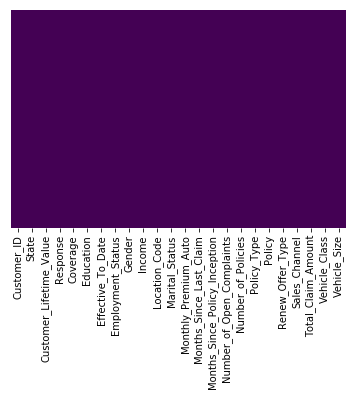

In [18]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [19]:
df.isnull().sum()

Customer_ID                      0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
Employment_Status                0
Gender                           0
Income                           0
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    0
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

There is no missing data

## Transform data
Once you have tidy data, a common first step is to transform it. **Transformation** includes narrowing in on observations of interest (like all people in one city, or all data from the last year), creating new variables that are functions of existing variables (like computing velocity from speed and time), and calculating a set of summary statistics (like counts or means). Together, tidying and transforming are called wrangling, because getting your data in a form that’s natural to work with often feels like a fight!

In [5]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [6]:
df.describe(exclude=[np.number])

,Customer,State,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
count,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134
unique,9134,5,2,3,5,59,5,2,3,3,3,9,4,4,6,3
top,IM94808,California,No,Basic,Bachelor,1/10/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Four-Door Car,Medsize
freq,1,3150,7826,5568,2748,195,5698,4658,5779,5298,6788,3426,3752,3477,4621,6424


In [ ]:
print('Latest Timestamp: ', df.Effective_To_Date.max())
print('First Timestamp: ', df.Effective_To_Date.min())

In [ ]:
# Betrachteter Zeitraum:
print(df.Effective_To_Date.min())
print(df.Effective_To_Date.max())

In [ ]:
# Distribution Gender
print('Count unique Customers', len(df.Customer))
print('Female: ',df[df.Gender == 'F'].shape[0])
print('Male:',df[df.Gender == 'M'].shape[0])

### Desciptiv Statistics
#### Measures of central trendency

## Visualize data
Once you have tidy data with the variables you need, there are two main engines of knowledge generation: visualisation and modelling. These have complementary strengths and weaknesses so any real analysis will iterate between them many times.

+ Boxplots
+ Histogramme
+ Scatter (e.g. Gender Distribution, Income in Bezug auf Ausgaben und Geschlecht, Income in Bezug auf Total_Claim_Account)
+ Gender: Verhalten im Bezug auf den Mariat_Status, Was für ein AutoType hat welches Geschlecht? => neue Variable
+ Karte mit den States mit einbauen, Anteile anzeigen, Berufsbildung, => es geht hier um eine Marketinganalyse
+ Durchschnittlicher Spending

**Visualisation** is a fundamentally human activity. A good visualisation will show you things that you did not expect, or raise new questions about the data. A good visualisation might also hint that you’re asking the wrong question, or you need to collect different data. Visualisations can surprise you, but don’t scale particularly well because they require a human to interpret them.

## Models
**Models** are complementary tools to visualisation. Once you have made your questions sufficiently precise, you can use a model to answer them. Models are a fundamentally mathematical or computational tool, so they generally scale well. But every model makes assumptions, and by its very nature a model cannot question its own assumptions. That means a model cannot fundamentally surprise you.

## Communication
The last step is **communication**, an absolutely critical part of any data analysis project. It doesn’t matter how well your models and visualisation have led you to understand the data unless you can also communicate your results to others.

Surrounding all these tools is **programming**. Programming is a cross-cutting tool that you use in every part of the project. You don’t need to be an expert programmer to be a data scientist, but learning more about programming pays off because becoming a better programmer allows you to automate common tasks, and solve new problems with greater ease.

Source: Wickham/Grolemund, 2016

Das Projekt folgt dem __Vorgehensmodell__ von CRISP_DM.

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png" width="400"/>

# BUSINESS UNDERSTANDING: Ursprung und grober Inhalt des Datensatzes

__ToDo:__
+ Woher sind die Daten?
+ In welchem Rahmen wurden sie erhoben?
+ Welchen Umfang haben sie?

In [ ]:
#import sys
#if not sys.warnoptions:
import warnings
warnings.simplefilter("ignore")

In [ ]:
import pandas as pd
import numpy as np

## DATA UNDERSTANDING: Was wissen wir und was wollen wir wissen?

## Initiale Datensammlung

Der Datensatz ist von [hier](https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/).

In [ ]:
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
df = pd.read_csv('marketing_customer_marketing_raw_data.csv')

In [ ]:
df.shape

In [ ]:
display(df.head())

## Beschreibung der Daten 

In [ ]:
df.describe()

In [ ]:
df.describe(exclude=[np.number])

In [ ]:
df.isnull().sum()

## Datenexploration

## Betrachtung der Datenqualität

# DATA PREPARATION:

# MODELLING

# EVALUATION

# DEPLOYMENT

## Positives
## Negatives
## Next Steps

### Detect columns type

In [ ]:
df.info()

__Regression:__  
Customer Lifetime Value

__Classification:__  
Marital Status